# Exercise 8 - Muscle synergies, part I

## Load signal `E08_signal` and angle reference `E08_angle`

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('../signals/E08_signal.csv').values
angle = pd.read_csv('../signals/E08_angle.csv').values

print(data.shape)
print(angle.shape)

n_muscles = data.shape[1]

(115341, 8)
(115341, 1)


## Visualize raw emg and extract envelope

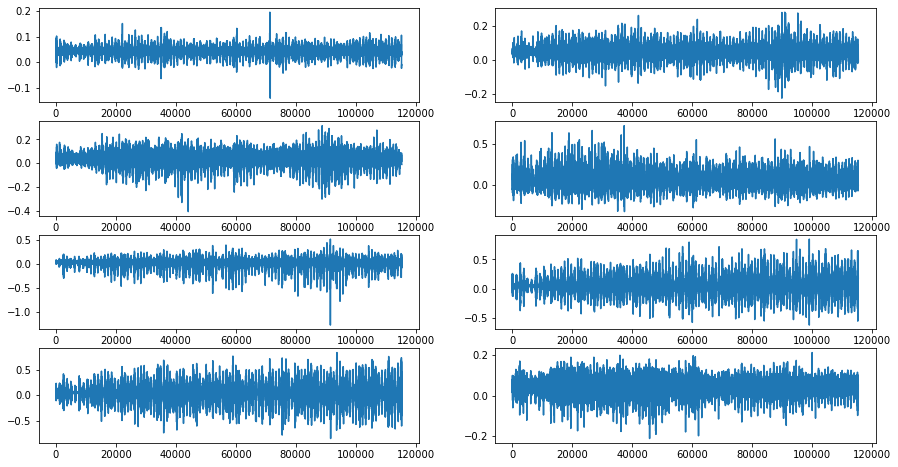

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(data[:,i])
plt.show()

In [30]:
from scipy.signal import butter, filtfilt

bp = [25, 450]
fs = 1000

b, a = butter(3, [x/fs for x in bp], btype='bandpass')

data_filt = filtfilt(b, a, data, axis=0)

In [31]:
bs = [49.5, 50.5]

b, a = butter(3, [x/fs for x in bs], btype='bandstop')

data_filt = filtfilt(b, a, data_filt, axis=0)

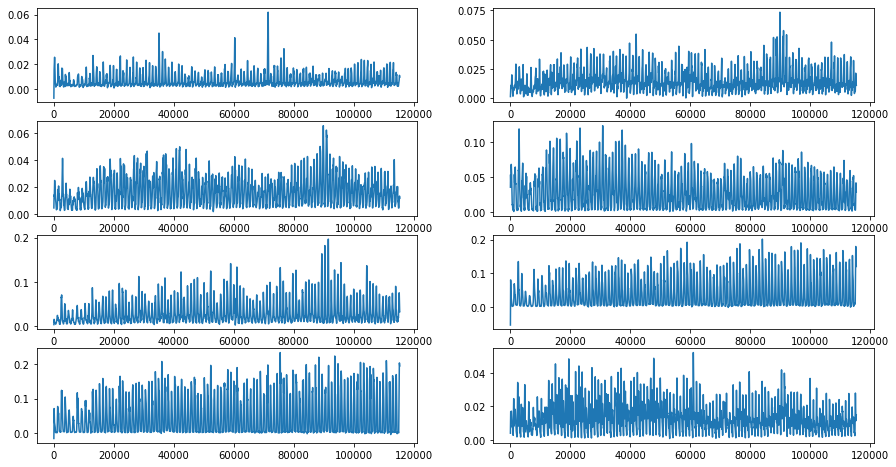

In [32]:
fc = 10
fs = 1000

b, a = butter(3, fc/fs, btype='lowpass')

env = filtfilt(b, a, np.abs(data_filt), axis=0)

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(env[:,i])
plt.show()

env = np.abs(env)

In [33]:
from scipy.signal import find_peaks

pk_locs = find_peaks(angle.squeeze(), height= 5, distance = 500)[0]
pk_locs = pk_locs[pk_locs > 5000]

pk_values = []
for i0, i1 in zip(pk_locs[:-1], pk_locs[1:]):
    pk_values.append(np.max(env[i0:i1,:], axis=0)) 
pk_values = np.asarray(pk_values)
norm_factors = np.median(pk_values, axis=0)
env_norm = np.asarray([env[:,i]/norm_factors[i] for i in range(n_muscles)]).transpose()

## Determine number of synergies

In [34]:
from sklearn.decomposition import NMF

def VAF(true_data, rec_data):

    return 1 - np.sum((true_data.flatten() - rec_data.flatten())**2)/np.sum(rec_data.flatten()**2)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


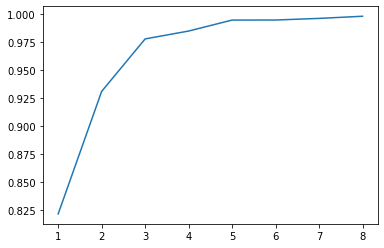

In [35]:
nmf_options = {
    'solver': 'mu',
    'max_iter': 500,
    'init': 'random'
}
W = []
H = []
rec = []
VAF_tot = []
VAF_muscles = []
for i in range(1,n_muscles+1):
    nmf = NMF(n_components=i, **nmf_options)
    H.append(nmf.fit_transform(env).transpose())
    W.append(nmf.components_.transpose())
    rec.append((W[-1]@H[-1]).transpose())
    VAF_tot.append(VAF(env, rec[-1]))
    VAF_muscles.append(
        [VAF(env[:,k], rec[-1][:,k]) for k in range(n_muscles)]
    )

VAF_tot = np.asarray(VAF_tot)
VAF_muscles = np.asarray(VAF_muscles)
plt.figure()
plt.plot(np.linspace(1,n_muscles,n_muscles), VAF_tot)
plt.show()

### Visualize single-muscle VAF curves

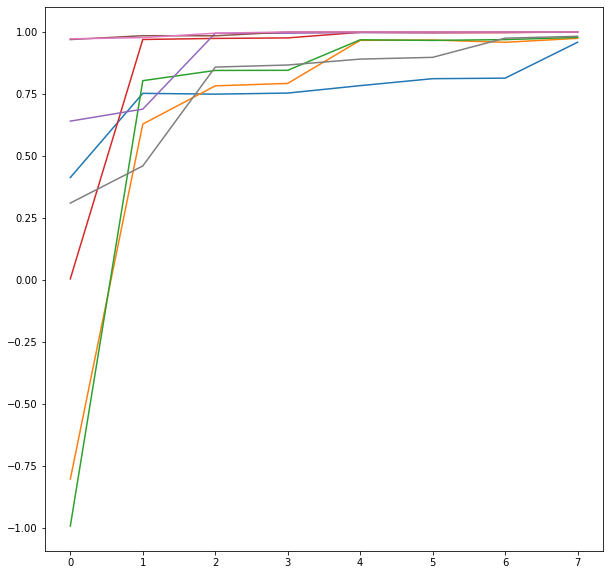

In [36]:
plt.figure(figsize=(10,10))
for i in range(n_muscles):
    plt.plot(VAF_muscles[:,i])
plt.show()

## Normalize H

In [37]:
from scipy.interpolate import interp1d

n_syn = 4

H_sel = H[n_syn-1]
W_sel = W[n_syn-1]
n_points = 360
H_norm = []
env_norm = []
rec_norm = []

for i0, i1 in zip(pk_locs[:-1], pk_locs[1:]):
    H_norm.append(
        interp1d(
            np.linspace(i0, i1, i1-i0).transpose(),
            H_sel[:,i0:i1],
            axis=1
        )(np.linspace(i0, i1, n_points))
    )
    env_norm.append(
        interp1d(
            np.linspace(i0, i1, i1-i0).transpose(),
            env[i0:i1,:],
            axis=0
        )(np.linspace(i0, i1, n_points))
    )
    rec_norm.append(
        interp1d(
            np.linspace(i0, i1, i1-i0).transpose(),
            rec[n_syn-1][i0:i1,:],
            axis=0
        )(np.linspace(i0, i1, n_points))
    )
    

H_norm = np.asarray(H_norm)
env_norm = np.asarray(env_norm)
rec_norm = np.asarray(rec_norm)
print(H_norm.shape)
H_norm=np.mean(H_norm, axis=0).squeeze()
env_norm=np.mean(env_norm, axis=0).squeeze()
rec_norm=np.mean(rec_norm, axis=0).squeeze()
print(H_norm.shape)
print(env_norm.shape)

(99, 4, 360)
(4, 360)
(360, 8)


## Visualize synergies

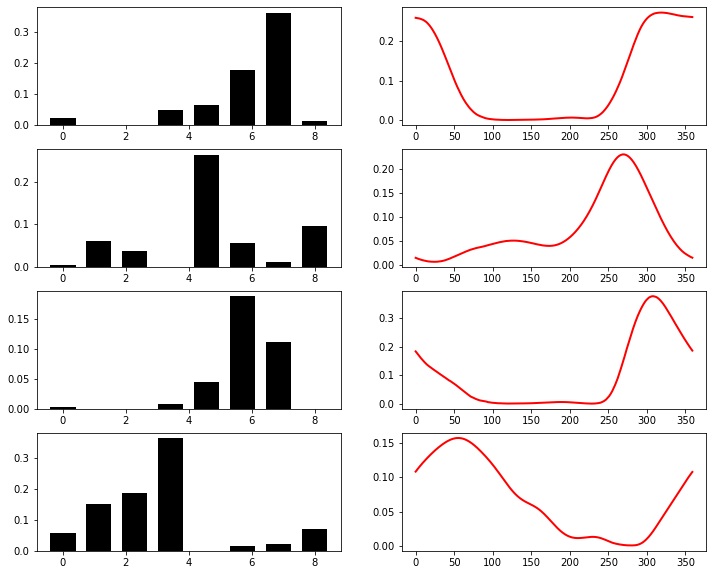

In [38]:
fig, ax = plt.subplots(n_syn, 2, figsize=(12,10))

for k in range(n_syn):
    ax[k,0].bar(np.linspace(0,n_muscles, n_muscles),W_sel[:,k], facecolor='k')
    ax[k,1].plot(H_norm[k,:], 'r', lw=2)

plt.show()

## Visualize average (on 360 samples) and reconstructed profiles for each muscle

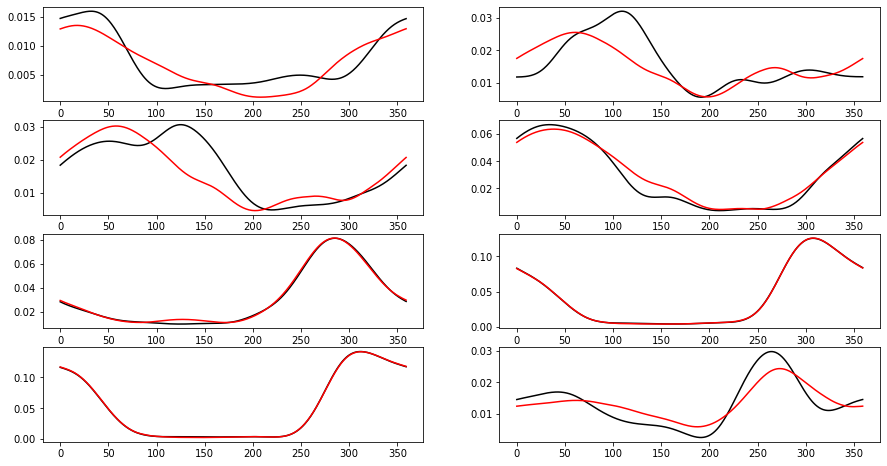

In [39]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(env_norm[:,i], 'k')
    ax[row, col].plot(rec_norm[:,i], 'r')
plt.show()